In [1]:
import os, random, numpy as np, torch

SEED = 42
def seed_everything(seed=SEED):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

def seed_worker(worker_id):
    worker_seed = (SEED + worker_id) % 2**32
    np.random.seed(worker_seed); random.seed(worker_seed)

Device: cuda


In [2]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])

In [3]:
import os
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit

BASE_DIR = os.path.join("..", "002_cancer")
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

BATCH   = 32
EPOCHS  = 30   # puedes subir/bajar
NUM_WORKERS = 0 if os.name=="nt" else 4
PIN = (DEVICE.type == "cuda")

# Dataset TRAIN completo para hacer split si no existe carpeta "val"
train_full = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
y = [lbl for _, lbl in train_full.samples]

if os.path.isdir(VAL_DIR) and all(os.path.isdir(os.path.join(VAL_DIR, c)) for c in ["Benign","Malignant"]):
    train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
    val_ds   = datasets.ImageFolder(VAL_DIR,   transform=val_test_transforms)
else:
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    train_idx, val_idx = next(sss.split(np.zeros(len(y)), y))
    train_ds = Subset(train_full, train_idx);  train_ds.dataset.transform = train_transforms
    val_ds   = Subset(train_full, val_idx);    val_ds.dataset.transform   = val_test_transforms

test_ds  = datasets.ImageFolder(TEST_DIR, transform=val_test_transforms)

class_to_idx = train_full.class_to_idx
idx_to_class = {v:k for k,v in class_to_idx.items()}
print("Clases:", class_to_idx)
print(f"Train={len(train_ds)} | Val={len(val_ds)} | Test={len(test_ds)}")

g = torch.Generator(); g.manual_seed(SEED)
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=NUM_WORKERS,
                          pin_memory=PIN, worker_init_fn=seed_worker, generator=g)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS,
                          pin_memory=PIN, worker_init_fn=seed_worker)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS,
                          pin_memory=PIN, worker_init_fn=seed_worker)

Clases: {'Benign': 0, 'Malignant': 1}
Train=9503 | Val=2376 | Test=2000


In [4]:
import torch.nn as nn
import math

def _gn_groups(ch):
    # 32 es estándar; si no divide, cae a 16/8/4/1
    for g in [32,16,8,4,1]:
        if ch % g == 0: return g
    return 1

class ConvGNReLU(nn.Sequential):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1):
        super().__init__(
            nn.Conv2d(in_ch, out_ch, kernel_size=k, stride=s, padding=p, bias=False),
            nn.GroupNorm(_gn_groups(out_ch), out_ch),
            nn.ReLU(inplace=True),
        )

class StableCNN(nn.Module):
    def __init__(self, in_ch=3, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            ConvGNReLU(in_ch,   64),
            ConvGNReLU(64,      64),
            nn.MaxPool2d(2),                 # 224 -> 112

            ConvGNReLU(64,     128),
            ConvGNReLU(128,    128),
            nn.MaxPool2d(2),                 # 112 -> 56

            ConvGNReLU(128,    256),
            ConvGNReLU(256,    256),
            nn.MaxPool2d(2),                 # 56 -> 28

            ConvGNReLU(256,    256),
            nn.MaxPool2d(2),                 # 28 -> 14
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
        )
        self._init()

    def _init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x); x = self.pool(x); x = self.head(x)
        return x

model = StableCNN(in_ch=3, num_classes=2).to(DEVICE)
print(model)

StableCNN(
  (features): Sequential(
    (0): ConvGNReLU(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (2): ReLU(inplace=True)
    )
    (1): ConvGNReLU(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (2): ReLU(inplace=True)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ConvGNReLU(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (2): ReLU(inplace=True)
    )
    (4): ConvGNReLU(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (2): ReLU(inplace=True)
    )
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

In [5]:
import torch, torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# Label Smoothing CE (evita sobreajuste y picos)
class LabelSmoothingCE(nn.Module):
    def __init__(self, eps=0.1):
        super().__init__()
        self.eps = eps
        self.log_softmax = nn.LogSoftmax(dim=1)
    def forward(self, logits, target):
        n_classes = logits.size(1)
        logprobs  = self.log_softmax(logits)
        nll = nn.functional.nll_loss(logprobs, target, reduction='mean')
        smooth = -logprobs.mean(dim=1).mean()
        return (1 - self.eps) * nll + self.eps * smooth

criterion = LabelSmoothingCE(eps=0.05)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=5e-4)

# Warmup manual + Cosine
WARMUP_EPOCHS = 3
scheduler_cos = CosineAnnealingLR(optimizer, T_max=max(1, EPOCHS - WARMUP_EPOCHS), eta_min=1e-6)

USE_AMP = (DEVICE.type == "cuda")
scaler  = torch.cuda.amp.GradScaler(enabled=USE_AMP)

def scheduler_step(epoch):
    if epoch < WARMUP_EPOCHS:
        for pg in optimizer.param_groups:
            pg['lr'] = 3e-4 * (epoch + 1) / WARMUP_EPOCHS
    else:
        scheduler_cos.step()

C:\Users\1cnac\AppData\Local\Temp\ipykernel_9340\2548712940.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler  = torch.cuda.amp.GradScaler(enabled=USE_AMP)


In [6]:
from collections import defaultdict
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_

history = defaultdict(list)

def run_epoch(loader, train_mode=True):
    model.train() if train_mode else model.eval()
    total, correct, running = 0, 0, 0.0

    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        if train_mode:
            optimizer.zero_grad(set_to_none=True)

        if USE_AMP:
            with torch.cuda.amp.autocast():
                logits = model(xb)
                loss   = criterion(logits, yb)
        else:
            logits = model(xb); loss = criterion(logits, yb)

        if train_mode:
            if USE_AMP:
                scaler.scale(loss).backward()
                # clipping evita “explosiones” → valid más suave
                scaler.unscale_(optimizer)
                clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer); scaler.update()
            else:
                loss.backward(); clip_grad_norm_(model.parameters(), 1.0); optimizer.step()

        running += loss.item() * xb.size(0)
        pred = logits.argmax(1)
        total += yb.size(0); correct += (pred == yb).sum().item()

    return running/total, correct/total

best_val = 0.0
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, True)
    va_loss, va_acc = run_epoch(val_loader,   False)

    scheduler_step(epoch)

    history["epoch"].append(epoch)
    history["train_loss"].append(tr_loss); history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc);   history["val_acc"].append(va_acc)

    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train_loss={tr_loss:.4f} acc={tr_acc:.3f} | "
          f"val_loss={va_loss:.4f} acc={va_acc:.3f} | "
          f"lr={optimizer.param_groups[0]['lr']:.6f}")

    if va_acc > best_val:
        best_val = va_acc
        torch.save({"model": model.state_dict(),
                    "class_to_idx": class_to_idx}, "stablecnn_best.pt")

C:\Users\1cnac\AppData\Local\Temp\ipykernel_9340\446544552.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[01/30] train_loss=0.4482 acc=0.808 | val_loss=0.3900 acc=0.842 | lr=0.000200
[02/30] train_loss=0.3913 acc=0.844 | val_loss=0.3751 acc=0.852 | lr=0.000300
[03/30] train_loss=0.3856 acc=0.849 | val_loss=0.3789 acc=0.852 | lr=0.000299
[04/30] train_loss=0.3817 acc=0.856 | val_loss=0.3583 acc=0.870 | lr=0.000296
[05/30] train_loss=0.3646 acc=0.866 | val_loss=0.3974 acc=0.851 | lr=0.000291
[06/30] train_loss=0.3524 acc=0.874 | val_loss=0.3566 acc=0.874 | lr=0.000284
[07/30] train_loss=0.3424 acc=0.880 | val_loss=0.3557 acc=0.863 | lr=0.000275
[08/30] train_loss=0.3329 acc=0.886 | val_loss=0.3460 acc=0.882 | lr=0.000265
[09/30] train_loss=0.3345 acc=0.887 | val_loss=0.3359 acc=0.880 | lr=0.000253
[10/30] train_loss=0.3264 acc=0.892 | val_loss=0.3223 acc=0.896 | lr=0.000240
[11/30] train_loss=0.3231 acc=0.892 | val_loss=0.3294 acc=0.888 | lr=0.000225
[12/30] train_loss=0.3118 acc=0.899 | val_loss=0.3174 acc=0.896 | lr=0.000210
[13/30] train_loss=0.3055 acc=0.904 | val_loss=0.3262 acc=0.889 

RuntimeError: cuDNN error: CUDNN_STATUS_EXECUTION_FAILED

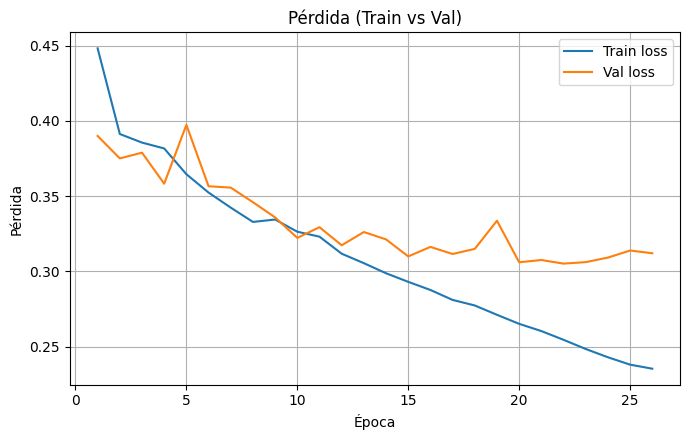

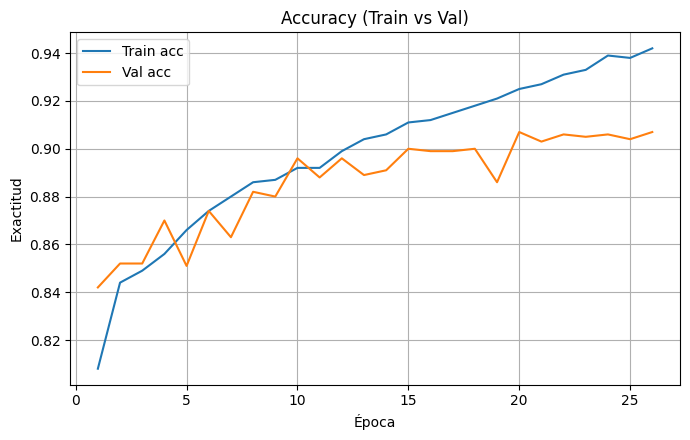

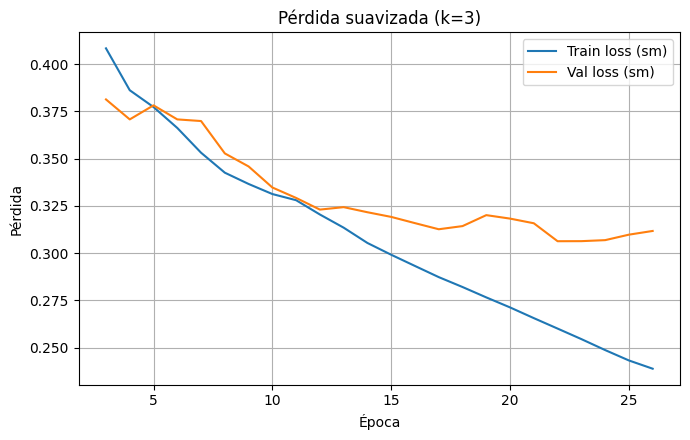

In [16]:
# === Curvas a partir de tus logs (épocas 1..26) ===
import numpy as np
import matplotlib.pyplot as plt

epochs = np.arange(1, 27)

train_loss = np.array([
    0.4482, 0.3913, 0.3856, 0.3817, 0.3646, 0.3524, 0.3424, 0.3329, 0.3345, 0.3264,
    0.3231, 0.3118, 0.3055, 0.2988, 0.2931, 0.2877, 0.2811, 0.2774, 0.2712, 0.2652,
    0.2604, 0.2546, 0.2485, 0.2430, 0.2381, 0.2354
], dtype=float)

train_acc = np.array([
    0.808, 0.844, 0.849, 0.856, 0.866, 0.874, 0.880, 0.886, 0.887, 0.892,
    0.892, 0.899, 0.904, 0.906, 0.911, 0.912, 0.915, 0.918, 0.921, 0.925,
    0.927, 0.931, 0.933, 0.939, 0.938, 0.942
], dtype=float)

val_loss = np.array([
    0.3900, 0.3751, 0.3789, 0.3583, 0.3974, 0.3566, 0.3557, 0.3460, 0.3359, 0.3223,
    0.3294, 0.3174, 0.3262, 0.3213, 0.3100, 0.3163, 0.3116, 0.3150, 0.3337, 0.3061,
    0.3076, 0.3052, 0.3062, 0.3092, 0.3139, 0.3121
], dtype=float)

val_acc = np.array([
    0.842, 0.852, 0.852, 0.870, 0.851, 0.874, 0.863, 0.882, 0.880, 0.896,
    0.888, 0.896, 0.889, 0.891, 0.900, 0.899, 0.899, 0.900, 0.886, 0.907,
    0.903, 0.906, 0.905, 0.906, 0.904, 0.907
], dtype=float)

# Pérdida
plt.figure(figsize=(7,4.5))
plt.plot(epochs, train_loss, label="Train loss")
plt.plot(epochs, val_loss,   label="Val loss")
plt.xlabel("Época"); plt.ylabel("Pérdida"); plt.title("Pérdida (Train vs Val)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

# Accuracy
plt.figure(figsize=(7,4.5))
plt.plot(epochs, train_acc, label="Train acc")
plt.plot(epochs, val_acc,   label="Val acc")
plt.xlabel("Época"); plt.ylabel("Exactitud"); plt.title("Accuracy (Train vs Val)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

# (Opcional) versión suavizada para ver tendencia
def smooth(x, k=3):
    x = np.array(x, float)
    if len(x) < k: return x
    return np.convolve(x, np.ones(k)/k, mode="valid")

k = 3
e2 = epochs[k-1:]
plt.figure(figsize=(7,4.5))
plt.plot(e2, smooth(train_loss,k), label="Train loss (sm)")
plt.plot(e2, smooth(val_loss,k),   label="Val loss (sm)")
plt.xlabel("Época"); plt.ylabel("Pérdida"); plt.title("Pérdida suavizada (k=3)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def smooth(x, k=3):
    if len(x) < k: return np.array(x, float)
    x = np.array(x, float)
    return np.convolve(x, np.ones(k)/k, mode="valid") 

ep   = np.array(history["epoch"])
trL, vaL = np.array(history["train_loss"]), np.array(history["val_loss"])
trA, vaA = np.array(history["train_acc"]),  np.array(history["val_acc"])

plt.figure(figsize=(14,4))
plt.subplot(1,2,1); plt.plot(ep, trL, label="Train"); plt.plot(ep, vaL, label="Val")
plt.title("Loss"); plt.xlabel("Época"); plt.legend(); plt.grid(True)

plt.subplot(1,2,2); plt.plot(ep, trA, label="Train"); plt.plot(ep, vaA, label="Val")
plt.title("Accuracy"); plt.xlabel("Época"); plt.legend(); plt.grid(True)
plt.show()

# versión suavizada (solo visual)
k = 3
if len(ep) >= k:
    e2 = ep[k-1:]
    plt.figure(figsize=(14,4))
    plt.subplot(1,2,1); plt.plot(e2, smooth(trL,k), label="Train"); plt.plot(e2, smooth(vaL,k), label="Val")
    plt.title(f"Loss (suavizado k={k})"); plt.legend(); plt.grid(True)
    plt.subplot(1,2,2); plt.plot(e2, smooth(trA,k), label="Train"); plt.plot(e2, smooth(vaA,k), label="Val")
    plt.title(f"Accuracy (suavizado k={k})"); plt.legend(); plt.grid(True)
    plt.show()

In [15]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

ckpt = torch.load("stablecnn_best.pt", map_location=DEVICE)
model.load_state_dict(ckpt["model"]); model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        if USE_AMP:
            with torch.cuda.amp.autocast():
                logits = model(xb)
        else:
            logits = model(xb)
        all_preds.append(logits.argmax(1).cpu().numpy())
        all_labels.append(yb.numpy())

y_pred = np.concatenate(all_preds); y_true = np.concatenate(all_labels)
print("Test acc:", (y_pred==y_true).mean().round(4))
print(classification_report(y_true, y_pred, target_names=[idx_to_class[0], idx_to_class[1]]))

cm = confusion_matrix(y_true, y_pred, labels=[0,1])

cmap = plt.cm.Blues     # <-- cámbialo por plt.cm.Oranges, Greens, Purples, magma, etc.
plt.figure(figsize=(4.6,4.6))
plt.imshow(cm, interpolation="nearest", cmap=cmap)
plt.title("Matriz de confusión")
plt.xticks([0,1], [idx_to_class[0], idx_to_class[1]], rotation=45, ha="right")
plt.yticks([0,1], [idx_to_class[0], idx_to_class[1]])
plt.xlabel("Predicción"); plt.ylabel("Real")
th = cm.max()/2.0
for i in range(2):
    for j in range(2):
        plt.text(j, i, int(cm[i,j]),
                 ha="center", va="center",
                 color="white" if cm[i,j] > th else "black")
plt.tight_layout(); plt.show()

C:\Users\1cnac\AppData\Local\Temp\ipykernel_9340\3506144337.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("stablecnn_best.pt", map_location=DEVICE)


RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
